# YOLO Image Detection Analysis
Analysis of object detection results from Telegram medical/cosmetic images

## Overview
This notebook analyzes YOLO detection results to identify:
- Most common objects detected
- Confidence score distributions
- Channel-specific patterns
- Temporal trends in detected objects

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# FIX: Go up one level from notebooks folder to project root
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent  # Go up one level
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
DETECTION_DIR = PROCESSED_DIR / "detections"

print(f"Notebook Directory: {NOTEBOOK_DIR}")
print(f"Project Root: {PROJECT_ROOT}")
print(f"Data Directory: {DATA_DIR}")
print(f"Processed Directory: {PROCESSED_DIR}")
print(f"Detection Directory: {DETECTION_DIR}")

# Debug: Check if directory exists and list files
print(f"\nChecking directory exists: {DETECTION_DIR.exists()}")
if DETECTION_DIR.exists():
    print(f"Files in detection directory:")
    for file in DETECTION_DIR.glob("*"):
        print(f"  - {file.name}")

Notebook Directory: c:\Users\It's Blue\medical-telegram-warehouse\notebooks
Project Root: c:\Users\It's Blue\medical-telegram-warehouse
Data Directory: c:\Users\It's Blue\medical-telegram-warehouse\data
Processed Directory: c:\Users\It's Blue\medical-telegram-warehouse\data\processed
Detection Directory: c:\Users\It's Blue\medical-telegram-warehouse\data\processed\detections

Checking directory exists: True
Files in detection directory:
  - detections_20260118_173029.csv
  - detections_20260118_173029.json
  - detections_20260118_173029.parquet
  - detections_20260118_173201.csv
  - detections_20260118_173201.json
  - detections_20260118_173201.parquet
  - summary_20260118_173029.json
  - summary_20260118_173201.json


## Section 1: Load Detection Data

In [20]:
print("\n" + "="*60)
print("SECTION 1: LOADING DETECTION DATA")
print("="*60)

# Find the latest detection files
parquet_files = list(DETECTION_DIR.glob("*.parquet"))
json_files = list(DETECTION_DIR.glob("detections_*.json"))
summary_files = list(DETECTION_DIR.glob("summary_*.json"))

print(f"Found {len(parquet_files)} Parquet files")
print(f"Found {len(json_files)} JSON files")
print(f"Found {len(summary_files)} summary files")

if parquet_files:
    print("\nParquet files found:")
    for pf in parquet_files:
        print(f"  - {pf.name} (modified: {pd.Timestamp(pf.stat().st_mtime, unit='s')})")
    
    # Load the latest parquet file
    try:
        latest_parquet = max(parquet_files, key=lambda x: x.stat().st_mtime)
        print(f"\nLoading latest detection file: {latest_parquet.name}")
        print(f"Full path: {latest_parquet}")
        
        df_detections = pd.read_parquet(latest_parquet)
        print(f"Loaded {len(df_detections)} detections")
        print(f"Columns: {list(df_detections.columns)}")
        
        # Display basic info
        print("\nDataFrame Info:")
        print(df_detections.info())
        
        print("\nFirst 5 rows:")
        display(df_detections.head())
        
    except Exception as e:
        print(f"Error loading Parquet file: {e}")
        print("\nTrying to load JSON file instead...")
        
        if json_files:
            latest_json = max(json_files, key=lambda x: x.stat().st_mtime)
            print(f"Loading JSON file: {latest_json.name}")
            df_detections = pd.read_json(latest_json)
            print(f"Loaded {len(df_detections)} detections from JSON")
            print(df_detections.head())
        else:
            print("No JSON files found either.")
            
else:
    print("No Parquet files found. Checking for other formats...")
    
    # Try CSV files
    csv_files = list(DETECTION_DIR.glob("*.csv"))
    if csv_files:
        print(f"Found {len(csv_files)} CSV files")
        latest_csv = max(csv_files, key=lambda x: x.stat().st_mtime)
        print(f"Loading CSV file: {latest_csv.name}")
        df_detections = pd.read_csv(latest_csv)
        print(f"Loaded {len(df_detections)} detections from CSV")
        print(df_detections.head())
    else:
        print("No detection files found.")
        print("Make sure you're running this notebook from the notebooks/ directory.")
        print("Your data should be at: ../data/processed/detections/")


SECTION 1: LOADING DETECTION DATA
Found 2 Parquet files
Found 2 JSON files
Found 2 summary files

Parquet files found:
  - detections_20260118_173029.parquet (modified: 2026-01-18 14:30:29.643832445)
  - detections_20260118_173201.parquet (modified: 2026-01-18 14:32:01.229305744)

Loading latest detection file: detections_20260118_173201.parquet
Full path: c:\Users\It's Blue\medical-telegram-warehouse\data\processed\detections\detections_20260118_173201.parquet
Loaded 1596 detections
Columns: ['image_path', 'image_name', 'channel_name', 'date_str', 'detected_class', 'confidence', 'x_center', 'y_center', 'box_width', 'box_height', 'original_width', 'original_height', 'processed_at']

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596 entries, 0 to 1595
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   image_path       1596 non-null   object        
 1   image_name       159

,image_path,image_name,channel_name,date_str,detected_class,confidence,x_center,y_center,box_width,box_height,original_width,original_height,processed_at
0,data\raw\images\chemed123\chemed123_11.jpg,chemed123_11.jpg,chemed123,unknown,clock,0.427296,0.477710,0.502149,0.928023,0.876820,1080,1080,2026-01-18 17:31:14.971754
1,data\raw\images\chemed123\chemed123_13.jpg,chemed123_13.jpg,chemed123,unknown,hot dog,0.503857,0.455839,0.541649,0.089840,0.092614,1280,1280,2026-01-18 17:31:15.069256
2,data\raw\images\chemed123\chemed123_13.jpg,chemed123_13.jpg,chemed123,unknown,donut,0.398998,0.504676,0.505833,0.084812,0.092360,1280,1280,2026-01-18 17:31:15.069408
3,data\raw\images\chemed123\chemed123_13.jpg,chemed123_13.jpg,chemed123,unknown,hot dog,0.309735,0.273442,0.520256,0.079700,0.078545,1280,1280,2026-01-18 17:31:15.069557
4,data\raw\images\chemed123\chemed123_13.jpg,chemed123_13.jpg,chemed123,unknown,donut,0.296923,0.415683,0.470582,0.076255,0.066891,1280,1280,2026-01-18 17:31:15.069694


## Section 2: Basic Statistics

In [21]:
print("\n" + "="*60)
print("SECTION 2: BASIC STATISTICS")
print("="*60)

if 'df_detections' in locals():
    # Summary statistics
    print("Summary Statistics:")
    print(f"Total images processed: {df_detections['image_path'].nunique()}")
    print(f"Total detections: {len(df_detections)}")
    print(f"Average detections per image: {len(df_detections) / df_detections['image_path'].nunique():.2f}")
    
    # Confidence statistics
    print(f"\nConfidence Statistics:")
    print(f"Mean confidence: {df_detections['confidence'].mean():.3f}")
    print(f"Median confidence: {df_detections['confidence'].median():.3f}")
    print(f"Min confidence: {df_detections['confidence'].min():.3f}")
    print(f"Max confidence: {df_detections['confidence'].max():.3f}")
    
    # Channel distribution
    print(f"\nChannel Distribution:")
    if 'channel_name' in df_detections.columns:
        channel_counts = df_detections['channel_name'].value_counts()
        for channel, count in channel_counts.items():
            print(f"  {channel}: {count} detections ({count/len(df_detections)*100:.1f}%)")
    else:
        print("  No 'channel_name' column found.")
        print(f"  Available columns: {list(df_detections.columns)}")
    
    # Class distribution
    print(f"\nTop Detected Classes:")
    if 'detected_class' in df_detections.columns:
        class_counts = df_detections['detected_class'].value_counts()
        for i, (cls, count) in enumerate(class_counts.head(10).items(), 1):
            print(f"  {i}. {cls}: {count} detections ({count/len(df_detections)*100:.1f}%)")
    else:
        print("  No 'detected_class' column found.")


SECTION 2: BASIC STATISTICS
Summary Statistics:
Total images processed: 478
Total detections: 1596
Average detections per image: 3.34

Confidence Statistics:
Mean confidence: 0.495
Median confidence: 0.460
Min confidence: 0.250
Max confidence: 0.956

Channel Distribution:
  tikvahpharma: 754 detections (47.2%)
  lobelia4cosmetics: 709 detections (44.4%)
  chemed123: 133 detections (8.3%)

Top Detected Classes:
  1. bottle: 982 detections (61.5%)
  2. person: 233 detections (14.6%)
  3. refrigerator: 60 detections (3.8%)
  4. book: 43 detections (2.7%)
  5. scissors: 41 detections (2.6%)
  6. hot dog: 22 detections (1.4%)
  7. cell phone: 20 detections (1.3%)
  8. dining table: 17 detections (1.1%)
  9. clock: 16 detections (1.0%)
  10. cup: 14 detections (0.9%)


## Section 3: Visualization


SECTION 3: VISUALIZATION


C:\Users\It's Blue\AppData\Local\Temp\ipykernel_60916\793223666.py:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 2].boxplot(box_data, labels=box_labels)


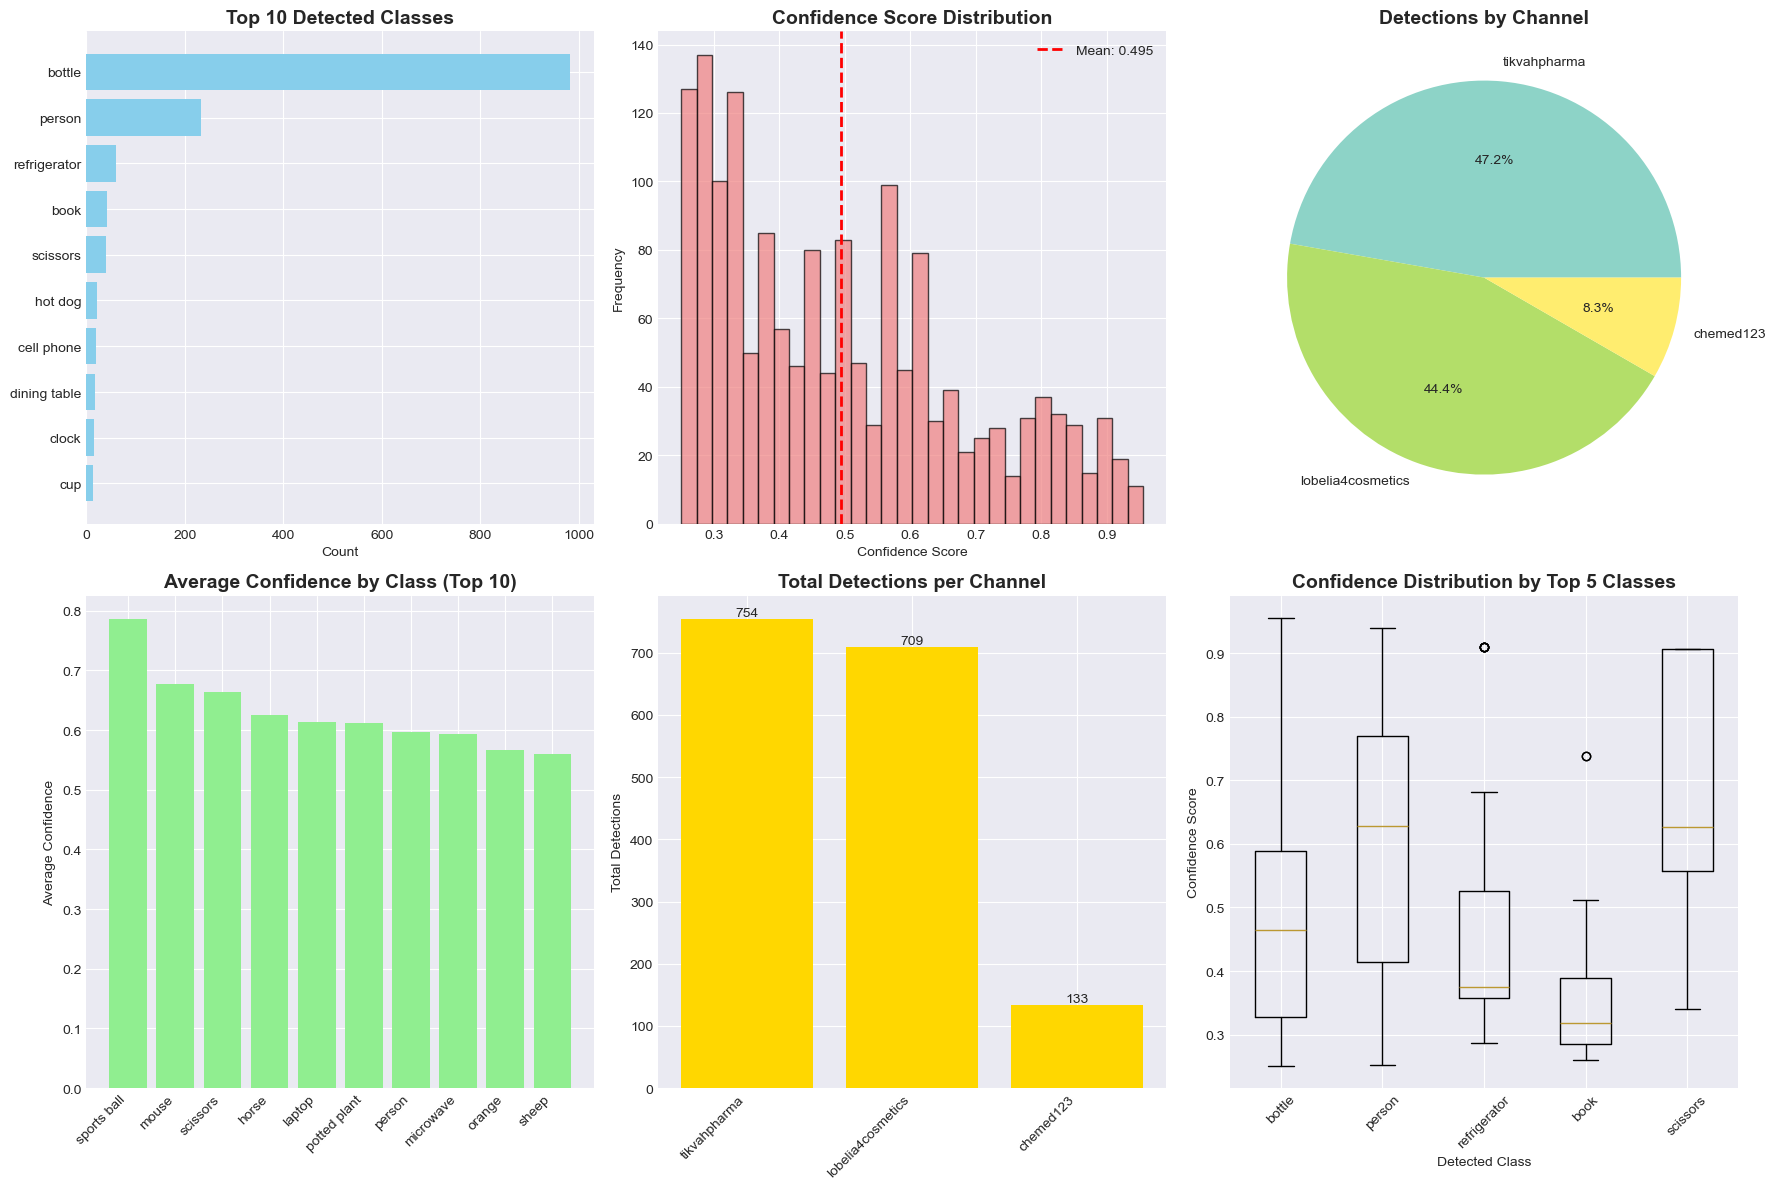

In [22]:
print("\n" + "="*60)
print("SECTION 3: VISUALIZATION")
print("="*60)

if 'df_detections' in locals():
    # Check required columns
    required_columns = ['detected_class', 'confidence']
    missing_columns = [col for col in required_columns if col not in df_detections.columns]
    
    if missing_columns:
        print(f"Missing columns for visualization: {missing_columns}")
        print(f"Available columns: {list(df_detections.columns)}")
    else:
        # Create visualizations
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 1. Top detected classes
        top_classes = df_detections['detected_class'].value_counts().head(10)
        axes[0, 0].barh(range(len(top_classes)), top_classes.values, color='skyblue')
        axes[0, 0].set_yticks(range(len(top_classes)))
        axes[0, 0].set_yticklabels(top_classes.index)
        axes[0, 0].set_xlabel('Count')
        axes[0, 0].set_title('Top 10 Detected Classes', fontsize=14, fontweight='bold')
        axes[0, 0].invert_yaxis()
        
        # 2. Confidence distribution
        axes[0, 1].hist(df_detections['confidence'], bins=30, edgecolor='black', alpha=0.7, color='lightcoral')
        axes[0, 1].set_xlabel('Confidence Score')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].set_title('Confidence Score Distribution', fontsize=14, fontweight='bold')
        axes[0, 1].axvline(df_detections['confidence'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_detections["confidence"].mean():.3f}')
        axes[0, 1].legend()
        
        # 3. Channel distribution (if available)
        if 'channel_name' in df_detections.columns:
            channel_data = df_detections['channel_name'].value_counts()
            axes[0, 2].pie(channel_data.values, labels=channel_data.index, autopct='%1.1f%%', 
                          colors=plt.cm.Set3(np.linspace(0, 1, len(channel_data))))
            axes[0, 2].set_title('Detections by Channel', fontsize=14, fontweight='bold')
        else:
            axes[0, 2].text(0.5, 0.5, 'No channel data\navailable', 
                           horizontalalignment='center', verticalalignment='center', 
                           transform=axes[0, 2].transAxes, fontsize=12)
            axes[0, 2].set_title('Detections by Channel', fontsize=14, fontweight='bold')
        
        # 4. Average confidence by class
        avg_confidence = df_detections.groupby('detected_class')['confidence'].mean().sort_values(ascending=False).head(10)
        axes[1, 0].bar(range(len(avg_confidence)), avg_confidence.values, color='lightgreen')
        axes[1, 0].set_xticks(range(len(avg_confidence)))
        axes[1, 0].set_xticklabels(avg_confidence.index, rotation=45, ha='right')
        axes[1, 0].set_ylabel('Average Confidence')
        axes[1, 0].set_title('Average Confidence by Class (Top 10)', fontsize=14, fontweight='bold')
        
        # 5. Detections per channel (if available)
        if 'channel_name' in df_detections.columns:
            channel_counts = df_detections['channel_name'].value_counts()
            bars = axes[1, 1].bar(range(len(channel_counts)), channel_counts.values, color='gold')
            axes[1, 1].set_xticks(range(len(channel_counts)))
            axes[1, 1].set_xticklabels(channel_counts.index, rotation=45, ha='right')
            axes[1, 1].set_ylabel('Total Detections')
            axes[1, 1].set_title('Total Detections per Channel', fontsize=14, fontweight='bold')
            
            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                               f'{int(height)}', ha='center', va='bottom')
        else:
            axes[1, 1].text(0.5, 0.5, 'No channel data\navailable', 
                           horizontalalignment='center', verticalalignment='center', 
                           transform=axes[1, 1].transAxes, fontsize=12)
            axes[1, 1].set_title('Total Detections per Channel', fontsize=14, fontweight='bold')
        
        # 6. Box plot of confidence by class
        top_5_classes = df_detections['detected_class'].value_counts().head(5).index
        df_top_5 = df_detections[df_detections['detected_class'].isin(top_5_classes)]
        
        box_data = []
        box_labels = []
        for cls in top_5_classes:
            box_data.append(df_top_5[df_top_5['detected_class'] == cls]['confidence'].values)
            box_labels.append(cls)
        
        axes[1, 2].boxplot(box_data, labels=box_labels)
        axes[1, 2].set_xlabel('Detected Class')
        axes[1, 2].set_ylabel('Confidence Score')
        axes[1, 2].set_title('Confidence Distribution by Top 5 Classes', fontsize=14, fontweight='bold')
        axes[1, 2].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()

## Section 4: Advanced Analysis


SECTION 4: ADVANCED ANALYSIS

1. Most Common Object Combinations:
Top 10 object pairs found together:
  bottle + bottle: 10872 images
  person + person: 577 images
  bottle + person: 291 images
  bottle + refrigerator: 144 images
  scissors + scissors: 33 images
  mouse + mouse: 28 images
  hot dog + hot dog: 24 images
  kite + person: 18 images
  cake + person: 14 images
  person + surfboard: 13 images

2. Temporal Analysis:
  No valid dates found in the data.

3. Spatial Analysis (Bounding Box Statistics):
      x_center  y_center  box_width  box_height
mean  0.524058  0.520819   0.211529    0.322404
std   0.193207  0.208428   0.247356    0.297029


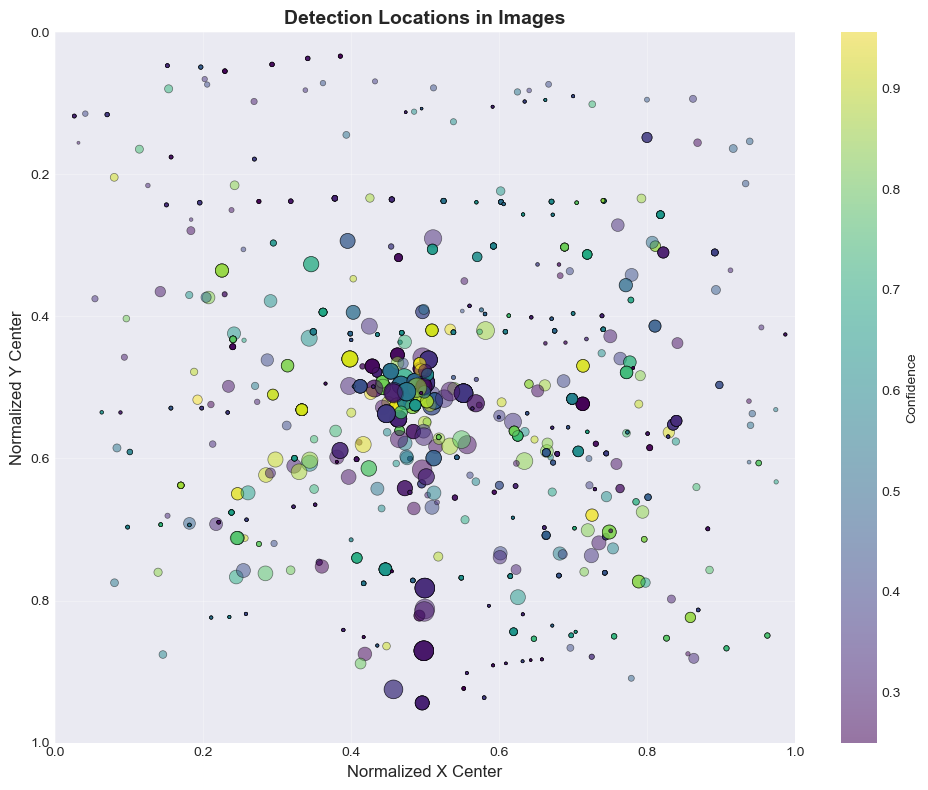

In [23]:
print("\n" + "="*60)
print("SECTION 4: ADVANCED ANALYSIS")
print("="*60)

if 'df_detections' in locals():
    # 1. Most common object combinations in images
    print("\n1. Most Common Object Combinations:")
    
    # Group detections by image
    image_groups = df_detections.groupby('image_path')['detected_class'].apply(list)
    
    # Find common pairs
    from collections import Counter
    from itertools import combinations
    
    object_pairs = Counter()
    for objects in image_groups:
        if len(objects) >= 2:
            for pair in combinations(sorted(objects), 2):
                object_pairs[pair] += 1
    
    print("Top 10 object pairs found together:")
    for (obj1, obj2), count in object_pairs.most_common(10):
        print(f"  {obj1} + {obj2}: {count} images")
    
    # 2. Temporal analysis if dates are available
    if 'date_str' in df_detections.columns and df_detections['date_str'].notna().any():
        print("\n2. Temporal Analysis:")
        
        # Convert date strings to datetime
        df_detections['date'] = pd.to_datetime(df_detections['date_str'], errors='coerce')
        
        if df_detections['date'].notna().any():
            daily_counts = df_detections.groupby('date').size()
            
            plt.figure(figsize=(12, 6))
            daily_counts.plot(marker='o', linestyle='-', color='purple', linewidth=2, markersize=8)
            plt.xlabel('Date', fontsize=12)
            plt.ylabel('Number of Detections', fontsize=12)
            plt.title('Daily Detection Counts', fontsize=14, fontweight='bold')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        else:
            print("  No valid dates found in the data.")
    else:
        print("\n2. Temporal Analysis: No date information available.")
    
    # 3. Spatial analysis of bounding boxes (if available)
    spatial_columns = ['x_center', 'y_center', 'box_width', 'box_height']
    if all(col in df_detections.columns for col in spatial_columns):
        print("\n3. Spatial Analysis (Bounding Box Statistics):")
        
        spatial_stats = df_detections.agg({
            'x_center': ['mean', 'std'],
            'y_center': ['mean', 'std'],
            'box_width': ['mean', 'std'],
            'box_height': ['mean', 'std']
        })
        
        print(spatial_stats)
        
        # Create scatter plot of detection locations
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(df_detections['x_center'], df_detections['y_center'], 
                    alpha=0.5, s=df_detections['box_width'] * 200, 
                    c=df_detections['confidence'], cmap='viridis', edgecolors='black', linewidth=0.5)
        plt.colorbar(scatter, label='Confidence')
        plt.xlabel('Normalized X Center', fontsize=12)
        plt.ylabel('Normalized Y Center', fontsize=12)
        plt.title('Detection Locations in Images', fontsize=14, fontweight='bold')
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.gca().invert_yaxis()  # Images have origin at top-left
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("\n3. Spatial Analysis: Bounding box data not available.")

## Section 5: Business Insights


SECTION 5: BUSINESS INSIGHTS
Product Category Distribution:
  Cosmetic: 982 detections (61.5%)
  Other: 614 detections (38.5%)

Channel-Specific Insights:

chemed123:
  Total detections: 133
  Medical content: 0.0%
  Cosmetic content: 29.3%
  Packaging content: 0.0%

lobelia4cosmetics:
  Total detections: 709
  Medical content: 0.0%
  Cosmetic content: 70.5%
  Packaging content: 0.0%

tikvahpharma:
  Total detections: 754
  Medical content: 0.0%
  Cosmetic content: 58.8%
  Packaging content: 0.0%

Quality Analysis (Based on Confidence):
  Low confidence: 905 detections (56.7%)
  Medium confidence: 536 detections (33.6%)
  High confidence: 155 detections (9.7%)


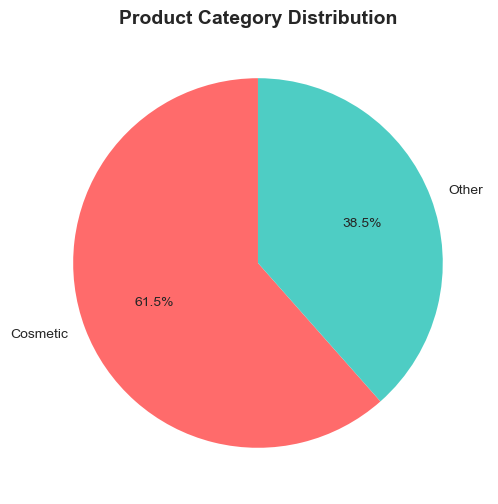

In [24]:
print("\n" + "="*60)
print("SECTION 5: BUSINESS INSIGHTS")
print("="*60)

if 'df_detections' in locals():
    # Define medical and cosmetic categories
    medical_keywords = ['medicine', 'pill', 'syringe', 'medical_device', 'medical', 'drug', 'pharmacy']
    cosmetic_keywords = ['cosmetic', 'cream', 'ointment', 'bottle', 'lotion', 'makeup', 'skincare']
    packaging_keywords = ['box', 'package', 'container', 'packaging', 'bottle']
    
    # Categorize detections
    def categorize_object(obj):
        obj_lower = str(obj).lower()
        if any(keyword in obj_lower for keyword in medical_keywords):
            return 'Medical'
        elif any(keyword in obj_lower for keyword in cosmetic_keywords):
            return 'Cosmetic'
        elif any(keyword in obj_lower for keyword in packaging_keywords):
            return 'Packaging'
        else:
            return 'Other'
    
    df_detections['category'] = df_detections['detected_class'].apply(categorize_object)
    
    print("Product Category Distribution:")
    category_counts = df_detections['category'].value_counts()
    for category, count in category_counts.items():
        percentage = count / len(df_detections) * 100
        print(f"  {category}: {count} detections ({percentage:.1f}%)")
    
    # Channel-specific insights
    if 'channel_name' in df_detections.columns:
        print("\nChannel-Specific Insights:")
        channel_category = df_detections.groupby(['channel_name', 'category']).size().unstack().fillna(0)
        
        for channel in channel_category.index:
            total = channel_category.loc[channel].sum()
            medical_pct = (channel_category.loc[channel, 'Medical'] / total * 100) if 'Medical' in channel_category.columns else 0
            cosmetic_pct = (channel_category.loc[channel, 'Cosmetic'] / total * 100) if 'Cosmetic' in channel_category.columns else 0
            packaging_pct = (channel_category.loc[channel, 'Packaging'] / total * 100) if 'Packaging' in channel_category.columns else 0
            
            print(f"\n{channel}:")
            print(f"  Total detections: {total}")
            print(f"  Medical content: {medical_pct:.1f}%")
            print(f"  Cosmetic content: {cosmetic_pct:.1f}%")
            print(f"  Packaging content: {packaging_pct:.1f}%")
    else:
        print("\nChannel-Specific Insights: No channel data available.")
    
    # Confidence quality analysis
    print("\nQuality Analysis (Based on Confidence):")
    df_detections['confidence_level'] = pd.cut(
        df_detections['confidence'],
        bins=[0, 0.5, 0.8, 1.0],
        labels=['Low', 'Medium', 'High']
    )
    
    quality_dist = df_detections['confidence_level'].value_counts()
    for level, count in quality_dist.items():
        percentage = count / len(df_detections) * 100
        print(f"  {level} confidence: {count} detections ({percentage:.1f}%)")
    
    # Display category distribution visualization
    plt.figure(figsize=(10, 6))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', 
            colors=colors[:len(category_counts)], startangle=90)
    plt.title('Product Category Distribution', fontsize=14, fontweight='bold')
    plt.show()

## Section 6: Export Analysis Results

In [25]:
print("\n" + "="*60)
print("SECTION 6: EXPORTING RESULTS")
print("="*60)

if 'df_detections' in locals():
    # Create summary DataFrame
    summary_data = {
        'analysis_date': [datetime.now().strftime('%Y-%m-%d %H:%M:%S')],
        'total_images': [df_detections['image_path'].nunique()],
        'total_detections': [len(df_detections)],
        'unique_classes': [df_detections['detected_class'].nunique()],
        'avg_confidence': [df_detections['confidence'].mean()],
        'avg_detections_per_image': [len(df_detections) / df_detections['image_path'].nunique()],
        'top_class': [df_detections['detected_class'].value_counts().index[0] if len(df_detections) > 0 else 'N/A'],
        'top_class_count': [df_detections['detected_class'].value_counts().iloc[0] if len(df_detections) > 0 else 0],
        'high_confidence_pct': [(df_detections['confidence'] >= 0.8).sum() / len(df_detections) * 100 if len(df_detections) > 0 else 0]
    }
    
    summary_df = pd.DataFrame(summary_data)
    
    # Save analysis results
    analysis_dir = PROCESSED_DIR / "analysis"
    analysis_dir.mkdir(exist_ok=True)
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Save summary
    summary_path = analysis_dir / f"detection_summary_{timestamp}.csv"
    summary_df.to_csv(summary_path, index=False)
    print(f"Summary saved to: {summary_path}")
    
    # Save detailed analysis
    if 'channel_name' in df_detections.columns:
        detailed_analysis = df_detections.groupby(['channel_name', 'detected_class']).agg({
            'confidence': ['count', 'mean', 'min', 'max'],
            'image_name': 'nunique'
        }).round(3)
        
        detailed_path = analysis_dir / f"detailed_analysis_{timestamp}.csv"
        detailed_analysis.to_csv(detailed_path)
        print(f"Detailed analysis saved to: {detailed_path}")
    else:
        detailed_analysis = df_detections.groupby(['detected_class']).agg({
            'confidence': ['count', 'mean', 'min', 'max']
        }).round(3)
        
        detailed_path = analysis_dir / f"detailed_analysis_{timestamp}.csv"
        detailed_analysis.to_csv(detailed_path)
        print(f"Detailed analysis saved to: {detailed_path}")
    
    # Save the categorized dataframe
    if 'category' in df_detections.columns:
        categorized_path = analysis_dir / f"categorized_detections_{timestamp}.csv"
        df_detections[['detected_class', 'category', 'confidence', 'confidence_level']].to_csv(categorized_path, index=False)
        print(f"Categorized detections saved to: {categorized_path}")
    
    print("\n" + "="*60)
    print("ANALYSIS COMPLETE!")
    print("="*60)
    print(f"\nResults saved to: {analysis_dir}")
    print(f"Timestamp: {timestamp}")
    print("\nFiles created:")
    print(f"  1. detection_summary_{timestamp}.csv")
    print(f"  2. detailed_analysis_{timestamp}.csv")
    print(f"  3. categorized_detections_{timestamp}.csv")
else:
    print("No data to export. Load detection data first.")


SECTION 6: EXPORTING RESULTS
Summary saved to: c:\Users\It's Blue\medical-telegram-warehouse\data\processed\analysis\detection_summary_20260118_182723.csv
Detailed analysis saved to: c:\Users\It's Blue\medical-telegram-warehouse\data\processed\analysis\detailed_analysis_20260118_182723.csv
Categorized detections saved to: c:\Users\It's Blue\medical-telegram-warehouse\data\processed\analysis\categorized_detections_20260118_182723.csv

ANALYSIS COMPLETE!

Results saved to: c:\Users\It's Blue\medical-telegram-warehouse\data\processed\analysis
Timestamp: 20260118_182723

Files created:
  1. detection_summary_20260118_182723.csv
  2. detailed_analysis_20260118_182723.csv
  3. categorized_detections_20260118_182723.csv
